# 1.使用深度可分离卷积训练fanshion_mnist数据集

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os,sys
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
%matplotlib inline

In [6]:
(x_train,y_train),(x_test,y_test) = keras.datasets.fashion_mnist.load_data()
x_val,x_train = x_train[:5000],x_train[5000:]
y_val,y_train = y_train[:5000],y_train[5000:]
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [7]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
x_train = x_train.reshape(-1,1).astype(np.float32)
x_train = stand.fit_transform(x_train).reshape(-1,28,28,1)
x_test = x_test.reshape(-1,1).astype(np.float32)
x_test = stand.transform(x_test).reshape(-1,28,28,1)
x_val = x_val.reshape(-1,1).astype(np.float32)
x_val = stand.transform(x_val).reshape(-1,28,28,1)

In [6]:
# 开始搭建模型
model = keras.models.Sequential(
    [layers.Conv2D(32,(3,3),padding='same',activation='selu',input_shape=(28,28,1)),
     # 采用深度可分离卷积
     layers.SeparableConv2D(32,(3,3),padding='same',activation='selu'),
     layers.SeparableConv2D(32,(3,3),padding='same',activation='selu'),
     layers.MaxPool2D(pool_size=2), # 经过池化之后，图片的宽度较小了，所以下一层要增加通道数来防止信息丢失
     layers.SeparableConv2D(64,(3,3),padding='same',activation='selu'),
     layers.SeparableConv2D(64,(3,3),padding='same',activation='selu'),
     layers.MaxPool2D(pool_size=2),
     layers.SeparableConv2D(128,(3,3),padding='same',activation='selu'),
     layers.SeparableConv2D(128,(3,3),padding='same',activation='selu'),
     layers.MaxPool2D(pool_size=2),
     layers.Flatten(), # 只有将图像展平之后才能输入全连接层
     layers.Dense(128,activation='selu'),
     layers.Dense(10,activation='softmax') # 通过softmax函数激活输出类别的概率
     ]
)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 separable_conv2d (Separable  (None, 28, 28, 32)       1344      
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 28, 28, 32)       1344      
 leConv2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 separable_conv2d_2 (Separab  (None, 14, 14, 64)       2400      
 leConv2D)                                              

In [8]:
logdir = './separable-cnn-selu-callbacks'
os.chdir('drive/MyDrive/Colab Notebooks')
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

In [9]:
history = model.fit(x_train,y_train,
                    epochs=100,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 21s 5ms/step - loss: 2.3033 - accuracy: 0.0984 - val_loss: 2.3031 - val_accuracy: 0.0980
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 2.3032 - accuracy: 0.1005 - val_loss: 2.3030 - val_accuracy: 0.0980
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 2.3028 - accuracy: 0.1025 - val_loss: 2.3037 - val_accuracy: 0.1024
Epoch 4/100
1719/1719 [==============================] - 8s 5ms/step - loss: 2.3028 - accuracy: 0.1023 - val_loss: 2.3042 - val_accuracy: 0.1002
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 2.3023 - accuracy: 0.1060 - val_loss: 2.3025 - val_accuracy: 0.1024
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 2.0654 - accuracy: 0.2379 - val_loss: 0.9373 - val_accuracy: 0.6408
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7779 - accuracy: 0.7050 - val_loss: 0.6703 - val_a

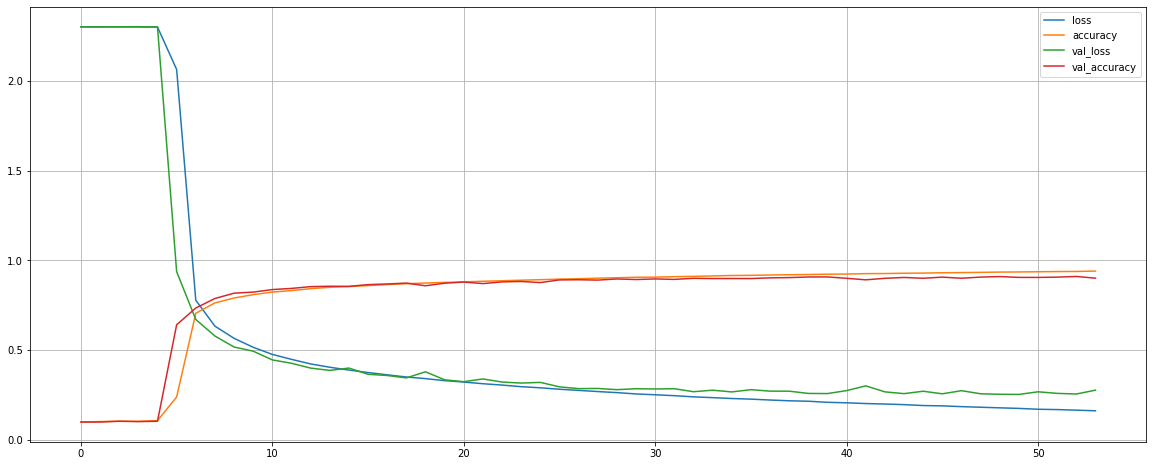

In [11]:
def plot_learning_curves(history):
  pd.DataFrame(history.history).plot(figsize=(20,8))
  plt.grid(True)
  plt.show()
plot_learning_curves(history)

In [12]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2832 - accuracy: 0.9036


[0.2831968367099762, 0.9035999774932861]

# 使用深度可分离卷积解决10-monkeys数据集分类

In [2]:
# 加载kaggle数据集
import json
os.chdir('drive/MyDrive/Colab Notebooks')
!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content/

- path is now set to: /content/


In [3]:
!kaggle datasets download -d slothkong/10-monkey-species

 97% 529M/547M [00:17<00:00, 28.6MB/s]
100% 547M/547M [00:17<00:00, 32.9MB/s]


In [ ]:
!unzip -o -d /content datasets/slothkong/10-monkey-species/10-monkey-species.zip

In [11]:
!ls

datasets  drive  monkey_labels.txt  sample_data  training  validation


In [12]:
!ls training/training/

n0  n1	n2  n3	n4  n5	n6  n7	n8  n9


In [13]:
!ls validation/validation/

n0  n1	n2  n3	n4  n5	n6  n7	n8  n9


In [14]:
!cat monkey_labels.txt

Label,  Latin Name           , Common Name                   , Train Images , Validation Images
n0   , alouatta_palliata	 , mantled_howler                , 131          , 26
n1   , erythrocebus_patas	 , patas_monkey                  , 139          , 28
n2   , cacajao_calvus	     , bald_uakari                   , 137          , 27
n3   , macaca_fuscata	     , japanese_macaque              , 152          , 30
n4   , cebuella_pygmea	     , pygmy_marmoset                , 131          , 26
n5   , cebus_capucinus	     , white_headed_capuchin         , 141          , 28
n6   , mico_argentatus	     , silvery_marmoset              , 132          , 26
n7   , saimiri_sciureus	     , common_squirrel_monkey        , 142          , 28
n8   , aotus_nigriceps	     , black_headed_night_monkey     , 133          , 27
n9   , trachypithecus_johnii , nilgiri_langur                , 132          , 26














In [15]:
train_dir = 'training/training/'
val_dir = 'validation/validation/'
label_file = 'monkey_labels.txt'
print(os.path.exists(train_dir))
print(os.path.exists(val_dir))
print(os.path.exists(label_file))

True
True
True


In [16]:
labels = pd.read_csv(label_file,header=0)
print(labels)


   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [22]:
height,width = 128, 128 
channels,batch_size = 3, 64
num_classes = 10
# 进行数据增强
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, # 把像素缩小到0-1之间
    rotation_range = 40, # 把图像岁间旋转0-90度之间
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True, # 水平翻转
) 

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(height,width),
                                                    batch_size=batch_size,seed=8,shuffle=True,
                                                    class_mode='categorical')

# 验证集只需要把像素缩小到0-1之间
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir,target_size=(height,width),
                                               batch_size=batch_size,seed=8,shuffle=True,
                                                    class_mode='categorical')
train = train_generator.samples
val = val_generator.samples
print(train,val)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [18]:
for i in range(1):
  x,y = train_generator.next()
  print(x.shape,y.shape) 
  print('-'*50)
  print(x) 
  print('-'*50)
  print(y) # 一个文件名就是一个类别

(64, 128, 128, 3) (64, 10)
--------------------------------------------------
[[[[3.04851294e-01 2.64856458e-01 1.38310581e-01]
   [4.95786995e-01 3.94389242e-01 2.02908054e-01]
   [4.20633584e-01 3.38024199e-01 1.69089034e-01]
   ...
   [5.72335720e-01 4.67466980e-01 2.33425181e-02]
   [4.14939433e-01 3.46417725e-01 1.64303891e-02]
   [4.26977724e-01 3.62443626e-01 6.34061769e-02]]

  [[2.80217290e-01 2.46253669e-01 1.26015544e-01]
   [4.54094082e-01 3.66228908e-01 1.88996807e-01]
   [4.39468950e-01 3.52150738e-01 1.77564934e-01]
   ...
   [6.93655670e-01 5.55311322e-01 2.25500479e-01]
   [8.52711737e-01 7.34426737e-01 4.33716595e-01]
   [9.36887503e-01 8.50771546e-01 5.11550784e-01]]

  [[2.66090780e-01 2.34010682e-01 1.15656100e-01]
   [4.04180408e-01 3.32325280e-01 1.72044992e-01]
   [4.58304316e-01 3.66277218e-01 1.86040848e-01]
   ...
   [5.84778786e-01 4.92827028e-01 1.69834614e-01]
   [7.87956119e-01 6.25654101e-01 2.51279831e-01]
   [8.49214852e-01 6.06018841e-01 2.26614803e-0

In [23]:
# 开始搭建模型
model = keras.models.Sequential(
    [layers.Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(width,height,channels)),
     layers.Conv2D(32,(3,3),padding='same',activation='relu'),
     layers.MaxPool2D(pool_size=2),
     layers.Conv2D(64,(3,3),padding='same',activation='relu'),
     layers.Conv2D(64,(3,3),padding='same',activation='relu'),
     layers.MaxPool2D(pool_size=2),  
     layers.Conv2D(128,(3,3),padding='same',activation='relu'),
     layers.Conv2D(128,(3,3),padding='same',activation='relu'),
     layers.MaxPool2D(pool_size=2), 
     layers.Flatten(),
     layers.Dense(128,activation='relu'),
     layers.Dense(num_classes,activation='softmax')]
)
model.compile(loss='categorical_crossentropy',
              optimizer = keras.optimizers.SGD(0.001),
              metrics=['accuracy'])

In [24]:
model.fit_generator(train_generator,
          epochs=300,
          steps_per_epoch=train // batch_size,
          validation_data = val_generator,
          validation_steps = val //batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/300
17/17 [==============================] - 32s 2s/step - loss: 2.3024 - accuracy: 0.1074 - val_loss: 2.3012 - val_accuracy: 0.1211
Epoch 2/300
17/17 [==============================] - 30s 2s/step - loss: 2.3011 - accuracy: 0.1054 - val_loss: 2.3010 - val_accuracy: 0.1211
Epoch 3/300
17/17 [==============================] - 30s 2s/step - loss: 2.3004 - accuracy: 0.1054 - val_loss: 2.2993 - val_accuracy: 0.1211
Epoch 4/300
17/17 [==============================] - 30s 2s/step - loss: 2.2993 - accuracy: 0.1083 - val_loss: 2.2984 - val_accuracy: 0.1289
Epoch 5/300
17/17 [==============================] - 29s 2s/step - loss: 2.2997 - accuracy: 0.1025 - val_loss: 2.2977 - val_accuracy: 0.1250
Epoch 6/300
17/17 [==============================] - 29s 2s/step - loss: 2.2992 - accuracy: 0.1122 - val_loss: 2.2956 - val_accuracy: 0.1406
Epoch 7/300
17/17 [==============================] - 29s 2s/step - loss: 2.2973 - accuracy: 0.1296 - val_loss: 2.2967 - val_accuracy: 0.1289
Epoch 8/300
1